In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score

def load_data(loc):
    #Create a pandas data frame from the csv data
    return pd.read_csv(loc)

#Load the data from the supplied cvs
data = load_data("body_fat_data.csv")

In [2]:
#Pre-process the data frame into suitable x and y data sets.
#Normalizes and drops unwanted columns
def prepare_data(data_frame):
    #Cull the initial index column as it contains no useful information for predicting body fat
    data_frame = data_frame.drop(data_frame.columns[0], axis=1)

    #The density and fat free weight columns can't be obtained by the goal of the experiement to
    #predict the body fat of indivuduals only by a scale and measuring tape. Thus they should
    #be removed to create a more accurate model
    data_frame = data_frame.drop(data_frame.columns[1], axis=1) #Density column
    data_frame = data_frame.drop(data_frame.columns[5], axis=1) #Fat free weight column

    #Extract the body fat column as our y *before* the data is normalized
    y = data_frame.iloc[:,0]
    #Then remove the body fat as this should not be in the input data x
    data_frame = data_frame.drop(data_frame.columns[0], axis=1)

    #Instantiate a new instance of the StandardScaler
    min_max_scaler = preprocessing.StandardScaler()
    #Pre-process the values in the data frame by using min-max normalization to get our x
    x = min_max_scaler.fit_transform(data_frame.values)

    #return the new x and y values
    return data_frame, x, y

#Generate our data_frame, x and y
start = time.time()
data_frame, x, y = prepare_data(data)
end = time.time()
print(end - start)

Best complexity parameter: 1.0


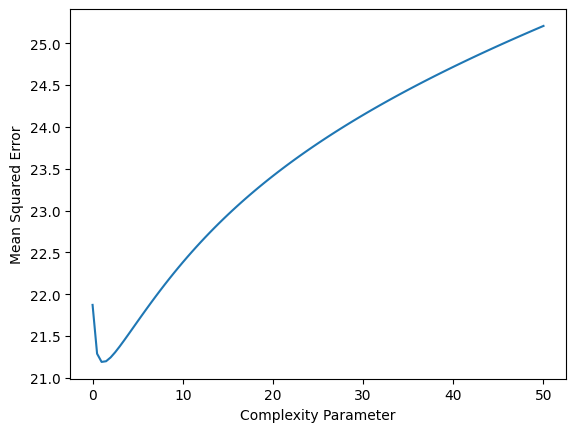

In [3]:
#Determinal the best complexity by using cross validation 
def get_best_complexity_value(x, y):
    #Create the KFold object. This is passed to cross_val_score for splitting 
    #the data set into sets of test and train
    k_fold_obj = KFold(n_splits=5)
    #To hold the results of the while loop, using mean scores as keys and complexity params as values
    results = {}
    cur_complexity = 0.0 
    #Loop for every increment of 0.5 to find the best complexity value
    while cur_complexity <= 50.0:
        #Instantiate an instance of the Ridge Regression model with the current complexity passed
        model = Ridge(alpha=cur_complexity)
        #
        cv_score_mean = cross_val_score(model, x, y, cv=k_fold_obj, scoring="neg_mean_squared_error")
        #Get the mean value of the returned array of floats containing the result of the cross validation
        #while also flipping the sign to get a positive final float result
        cv_score_mean = -cv_score_mean.mean()
        #Append this to the results dict
        results[cv_score_mean] = cur_complexity
        #Increment the current complexity to the next in the iteration
        cur_complexity = (cur_complexity + 0.5)

    #Plot the results of all complexity parameters and mean cv scores
    plt.plot(results.values(), results.keys())
    plt.ylabel("Mean Squared Error")
    plt.xlabel("Complexity Parameter")
    plt.savefig("figure1.png", bbox_inches="tight")

    #Choose the best complexity by grabbing the smallest value in the list of result keys
    #which are all the cv_score_mean results for every iteration
    best_complexity = results[min(list(results.keys()))]
    #Print the best complexity found, this should be 0.5
    print(f"Best complexity parameter: {best_complexity}")

    #return the best complexity value
    return best_complexity

#Determine the most suitable complexity for the data and model
best_complexity = get_best_complexity_value(x, y)

[9.657289673440001, 2.2862204485858117, 1.5453122626944036]
['Abdomen circumference (cm)', 'Weight (lbs)', 'Wrist circumference (cm)']


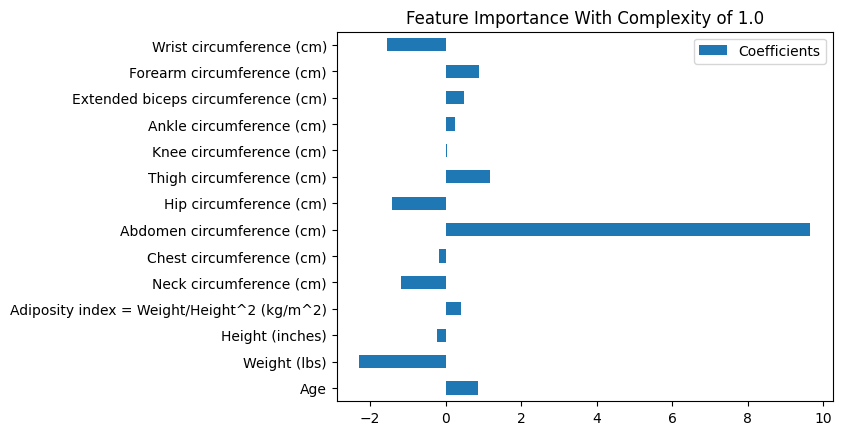

In [4]:
#Find the most influential feature on the model predictions
def find_feature_importance(x, y, best_complexity):
    #Instantiate our final model
    model = Ridge(alpha=best_complexity)
    #Train with all of the data using our chosen best complexity parameter
    model.fit(x, y)

    #Create lables for the graph from the original data frame
    labels = list(data_frame.columns)
    
    #Create data frame from the trained model's coefficients and use those to plot feature importance
    pd.DataFrame(model.coef_, columns=["Coefficients"], index=labels).plot(kind="barh")
    plt.title(f"Feature Importance With Complexity of {best_complexity}")
    plt.savefig("figure2.png", bbox_inches="tight")

    #Create coefficient -> feature label dictionary so the labels can be lookup after the 
    #coefficients are sorted. The absolute value should also be used when comparing
    features = {}
    for i in range(0, len(model.coef_)):
        features[abs(model.coef_[i])] = labels[i]

    #Now sort the keys based on their absolute value
    sorted_keys = sorted(features.keys())
    #Reverse the list so the most impactful starts at index 0
    sorted_keys.reverse()

    #Constuct both the most impactful features and their labels as two arrays
    most_impactful_coefs = [sorted_keys[0], sorted_keys[1], sorted_keys[2]]
    most_impactful_labels = [features[sorted_keys[0]], features[sorted_keys[1]], features[sorted_keys[2]]]
    
    #Return most impactful features
    return most_impactful_coefs, most_impactful_labels

#Find the most impactful features for the given x, y data and the complexity parameter
most_impactful_coefs, most_impactful_labels = find_feature_importance(x, y, best_complexity)

#Print the final output of the program
print(most_impactful_coefs)
print(most_impactful_labels)